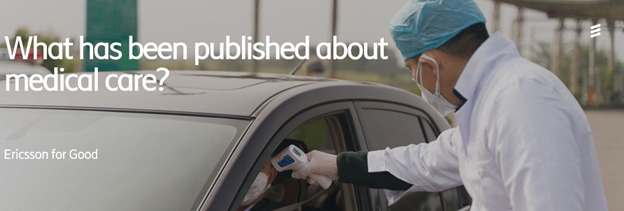

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks?taskId=572

<h1>Introduction</h1>
<p>As the number of reported coronavirus (COVID-19) cases and deaths continue to climb across the U.S. and around the world, it is crucial for health providers to be aware of what has been published about best practices in medical care relating to COVID-19. Having access to the latest research can help prevent future spread of the virus and potentially save lives. This document provides a way to access the most relevant data to answer the question “What has been published about medical care?”</p>

<h2>Subtasks</h2>

<p>The question “What has been published about medical care?” is composed of the 16 subtasks below.</p>
<ol>
<li>Resources to support skilled nursing facilities and long-term care facilities.</li>
<li>Mobilization of surge medical staff to address shortages in overwhelmed communities.</li>
<li>Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies.</li>
<li>Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients.</li>
<li>Outcomes data for COVID-19 after mechanical ventilation adjusted for age.</li>
<li>Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.</li>
<li>Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.</li>
<li>Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.</li>
<li>Best telemedicine practices, barriers and facilitators, and specific actions to remove/expand them within and across state boundaries.</li>
<li>Guidance on the simple things people can do at home to take care of sick people and manage disease.</li>
<li>Oral medications that might potentially work.</li>
<li>Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.</li>
<li>Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.</li>
<li>Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials.</li>
<li>Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials.</li>
<li>Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen).</li>
</ol>

<h2>Relevant, Simplified and Accessible Results</h2>

<p>Within this document, the most relevant research for each of the 16 subtasks above is presented in a simple, easy to use results table which contains the following:</p>
<ul>
    <li>a short summary of the results for each subtask</li>
    <li>the top five documents related to each subtask</li>
    <li>a brief two sentence summary for each of the top five documents for each subtask</li>
</ul>
<p>For convenience, each of the top five documents may be immediately accessed by clicking on the document title within the results table.</p>


<h1>Methodology</h1>
<p>
There are tens of thousands of scholarly articles related to COVID-19 and similar coronaviruses in the COVID-19 Open Research Dataset (CORD-19).  CORD-19 is growing rapidly each day as researchers learn more about the virus.  Because CORD-19 contains the most comprehensive bank of coronavirus research data available, it is the resource used for this text and data mining solution. 

Numerous algorithms were tested to determine which would provide the most relevant query results to assist researchers. It was determined that a combination of Python’s BM25 ranking function and Word2vec would be used to obtain the most accurate and relevant results.
</p>

<h2>Text Summarization With BM25 and Word2vec</h2>
<p>
Two models, BM25 and Word2vec, were used to analyze the text and produce the desired query results for each of the 16 subtasks.

Python's BM25 (Best Matching) ranking function ranks a set of documents according to their relevance in the given search query.

The query performs the following actions:

 - Filters documents to include only those published between 2012-2020 to ensure data relevance
 - Searches the combined fields of full text+title+abstract to produce more accurate results 
    
Word2vec summarizes CORD-19 by making predictions about a word's meaning based on its past appearance in the text. A Skip Gram Word2vec model was employed where the current word predicts the surrounding window of context words and weighs nearby context words more heavily than more distant context words.  The Skip Gram model, though it runs more slowly than other models, is better for handling infrequent words. 
</p>

<h1>Process Flow</h1>
<p> Below is the overall process flow that is used to obtain the final output that best answers the question "What Has Been Published About Medical Care?"
<ol>
<li>Train the BM25 model against the list of clean text (full text+title+abstract) from all the prefiltered documents.</li>  
<li> Construct the question key words which consist of: original question + list of customized synonyms for the questions + extra key words + common medical key words. </li>
<li> Apply the subtask's key words against the corpus to obtain the list of top ranked documents.</li>
<li> Apply text summarization for each top ranked document to obtain the top ranked sentences that match the question's key words. </li>
<li> Rank the top sentences for each document to produce the overall top ranked sentences for the subtask.</li>
<li> Display the top two sentences from all the top ranked documents as the overall summary.</li>
<li> Present the final results from the top ranked documents and the text summarization in an HTML table format.</li>
</ol>

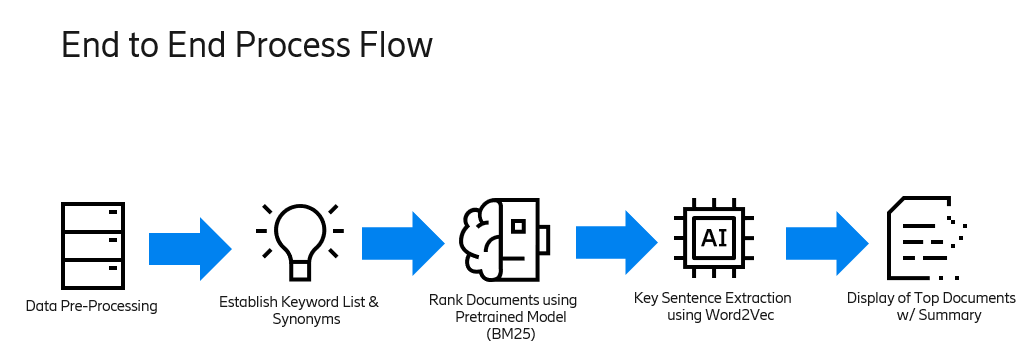

<h1>Libraries</h1>
<p>This project was created with common open source libraries used for Python and machine learning.</p>

In [ ]:
# Following librariers are not included in Kaggle and require install
!pip install rank_bm25
!pip install langdetect

In [ ]:
#
# Standard Python Libraries
#
import csv
import gc
import glob
import heapq
import json
import pickle
import os
import re
import string
import sys

#
# Libraries licensed under BSD
#
import numpy as np
import pandas as pd
from IPython.display import HTML
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

#
# Libraries licensed Apache 2.0
#
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from langdetect import detect

#
# Libraries licensed under LGPL
#
import gensim
from gensim.models import KeyedVectors

#
# Libraries liceensed under MIT
#
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from rank_bm25 import BM25Okapi

In [ ]:
%%javascript

// Disable scrolling in jupyter notebook

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<h2>Text Cleaning  and Data Loading Utility Functions</h2>
<p>The text is cleaned before performing data modeling to allow processing to proceed in a uniform manner.  The text is lemmatized (converted to its base form) to ensure accurate text analysis. The text is normalized by converting it to lowercase and removing punctuation and digits. Text in languages other than English are removed.</p>

In [ ]:
DATA_PATH = '/kaggle/input/CORD-19-research-challenge'
W2V_PATH = '/kaggle/input/covid19-w2v/'

stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def sent_to_words(sentences):
    #for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentences), deacc=True)) 
        
def remove_stopwords(texts):
    return [[word for word in doc if word not in stopwords] for doc in texts]

def clean_text(x):
    formatted_article_text = re.sub('[^a-zA-Z]', ' ', x)
    doc = re.sub(r'\s+', ' ', formatted_article_text)
    words = list(sent_to_words(doc))
    words_cleaned = remove_stopwords(words)
    tokens = [lemmatizer.lemmatize(w.strip()) for w in words_cleaned[0]]
    return tokens

def split_word(text, separator):
    tokenized_word = [text.split(separator) for doc in text]
    return tokenized_word

def get_year(date):
    # expected input format yyyy-mm-dd
    # case when date=NaN, passed in value is fload
    if isinstance(date, float):
        yr=""
    elif len(date)==0:
        yr=""
    else:            
        x = split_word(date, "-")
        yr = x[0][0]  
    return yr

def detect_lang(text):
    try:
        portion=text[0:400]
        lang=detect(portion)
    except Exception:
        lang=None
  
    return lang 


<h1>Load and Parse Data from Kaggle</h1>
<p>Data is received from Kaggle in a zipped file which must be unzipped to be usable. Once the file is unzipped, Python is used to generate a data frame so the data may be easily accessed.</p>
    

In [ ]:
# Input data files are available in the "../input/" directory.
# will list all files under the input directory


# class to be used to fetch json records
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)

    def __repr__(self):
         return f'{self.paper_id}: \n{self.abstract[:400]}...\n{self.body_text[:400]}...'

def doi_url(d): return f'http://{d}' if d.startswith('doi.org') else f'http://doi.org/{d}'

def load_data_from_kaggle():
    file_counter = 0
    outer_loop = True

    for dirname, _, filenames in os.walk(DATA_PATH):
        for filename in filenames:
            file_counter += 1
            print(filename)
            if file_counter > 10:
                outer_loop = False
                break
        else:
            continue
        break
            
        

    # Any results you write to the current directory are saved as output.

    root_path = '/kaggle/input/CORD-19-research-challenge/'
    all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
    filename = f'{root_path}metadata.csv'
    print(f'Metadata Filename: {filename}')
    len(all_json)

    # load in metadata
    #
    meta_data = pd.read_csv(filename, dtype={
            'doi': str,
            'pubmed_id': str,
            'Microsoft Academic Paper ID': str
            })

    print(len(meta_data))
    meta_data.head(2)

    # working with relevent fields
    #
    meta_data = meta_data[['sha','title','doi','abstract','publish_time','authors']]

    meta_data.abstract = meta_data.abstract.fillna(meta_data.title)
    print(f'record count: {len(meta_data)}')
    meta_data.head(2)

    # remove older years
    meta_data['publish_time_year'] = meta_data['publish_time'].str[:4]
    meta_data = meta_data[meta_data['publish_time_year'] >= '2012']
    meta_data = meta_data.reset_index(drop=True) 
    
    # removal of null and duplicate
    #
    duplicate_paper = ~(meta_data.title.isnull() | meta_data.abstract.isnull() | meta_data.doi.isnull()) & (meta_data.duplicated(subset=['title', 'abstract']))
    meta_data = meta_data[~duplicate_paper].reset_index(drop=True)
    len(meta_data)
    meta_data.doi = meta_data.doi.fillna('').apply(doi_url)
    first_row = FileReader(all_json[0])
    print(first_row)

    # Load the data into dataframe
    #
    dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
    counter = 0
    for idx, entry in enumerate(all_json):
        if idx % (len(all_json) // 10) == 0:
            print(f'Processing index: {idx} of {len(all_json)}')
    
        try:
            content = FileReader(entry)
            dict_['paper_id'].append(content.paper_id)
            dict_['abstract'].append(content.abstract)
            dict_['body_text'].append(content.body_text)
        except:
            counter+= 1       

    dataframe = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
    print(f'Total records rejected due to wrong structure: {counter}')
    dataframe.head()

    # perform join between metadata and json files
    #
    left = meta_data[['sha','title','doi','abstract','publish_time','authors']]
    right = dataframe[['paper_id','body_text']]
    dataset = pd.merge(left, right, left_on='sha', right_on='paper_id', how='left')
    print(f'dataset ->: {len(dataframe)}')
    print(f'left ->: {len(left)}')
    print(f'right ->: {len(right)}')
    print(f'final ->: {len(dataset)}')

    del left
    del right
    del meta_data
    del dataframe  

    # fill 'body_text' with 'title' where it's null
    dataset.body_text = dataset.body_text.fillna(dataset.title)

    # remode 'paper_id'
    dataset = dataset.drop(['paper_id'], axis = 1)

    # count of records
    len(dataset)

    # considering usefull columns
    dataset = dataset.rename(columns={"sha": "document_id", "body_text": "full_text"})
    dataset = dataset[['title','doi','abstract','authors','full_text','publish_time']]
    dataset.head(2)
    
    # Utilize English only documents
    dataset['language'] = dataset['full_text'].apply(lambda x: detect_lang(x))
    dataset = dataset[dataset['language'] == 'en'] 
    
    dataframe = dataset
    
    del dataset 
    gc.collect() 
    
    return dataframe


In [ ]:
# Load directly from Kaggle - will do this after Legal review
#
df_orig_data = load_data_from_kaggle()

 <h1>Dataset Cleansing</h1>
 <p>The dataset is cleaned further, lemmatized, and tokenized.</p>

In [ ]:
clean_text_list = []

for index, data in df_orig_data.iterrows():
    if isinstance(data['title'], float): 
        title = ""
    else:
        title = data['title']

    if isinstance(data['abstract'], float): 
        abstract = ""
    else:
        abstract = data['abstract']

    if isinstance(data['full_text'], float): 
        full_text = ""
    else:
        full_text = data['full_text']

    text_to_clean = title + " " + abstract + " " + full_text
    clean_text_list.append(clean_text(text_to_clean))                


<h2>Define the Subtasks with Helper Words to be Used as Queries on the BM25 Model</h2>

<p>Task Info: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks?taskId=572</p>

Each of the 16 subtasks that help answer the overarching question "What has been published about medical care" are further defined to help achieve better search results. Synonyms and additional key words are provided with each subtask to further refine the results.

In [ ]:
#
# List of questions as defined by the task
#
task_ques_list = ['Resources to support skilled nursing facilities and long term care facilities.', \
                  'Mobilization of surge medical staff to address shortages in overwhelmed communities', \
                  'Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies', \
                  'Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients',
                  'Outcomes data for COVID-19 after mechanical ventilation adjusted for age', \
                  'Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.', \
                  'Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.', \
                  'Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.', \
                  'Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.', \
                  'Guidance on the simple things people can do at home to take care of sick people and manage disease', \
                  'Oral medications that might potentially work', \
                  'Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually', \
                  'Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcome', \
                  'Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials', \
                  'Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials', \
                  'Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)']


In [ ]:
#
# For each question, additional topic related words are provided to hone in optimal results
#
common_key = 'coronavirus SARS-CoV-2 2019-nCov COVID-19 COVID19 Novel Coronavirus SARS-CoV-2'

extra_ques1='HHSC CMS HWS CDC HHAC DSHA AMDA LTCFs SPICE Isolate Isolation pandemic disinfectants cleaning supplies no-touch thermometers shortages contingency plans repurpose alternative machines specialized beds nurse skill resource diagnostics tools effectiveness health care PPE coronavirus elder care elderly disabled elderly personnel ill residents supplies staffing postmortem education training planning checklist self-assess strengths weaknesses preparedness mandatory requirements standards important areas risk assessments measures infection control protocol PACE personal protective equipment (PPE) face masks eye protection gowns gloves Centers for Medicare & Medicaid Services (CMS) guidance Programs All-Inclusive Care protocols high-risk population multiple chronic illnesses'
extra_ques2='pandemic medical personnel mobilize intensive care unit (ICU) critical care unit (CCU) surge capacity registered nurses critically ill critical acute care telephone triage reactivate licenses reactivation states barriers child care options coverage expanding onboard surging demand mobilize widespread strict criteria for admissions postpone accelerate discharge alternative delivery platforms essential repurpose upskill rapid training reassignment shiftwork low risk settings final year medical nursing students relocating recruit '
extra_ques3='percentage % virus age years old died respiratory heart kidney renal lung liver breathing coughing infection MOF multiple organ failure sepsis distal organs organ crosstalk brain-lung communication acute kidney injury (AKI) extra-pulmonary organ failure cardiovascular neurologic function cirrhosis mechanical ventilation hypoxemia ventilator pressures renal function septic shock acidosis heart failure CHF cardiac disease BMI circulating inflammatory mediators SISR'
extra_ques4='age percentage % virus respiratory breathing coughing infection clinical management guidelines acute respiratory distress syndrome (ARDS) severe ARDS refractory medical management benefit conventional treatment supported venovenous restricted specialised complex therapies therapeutic interventions planning preparedness judicious resource allocation training personnel adhering adherence strict infection control measures crucial components action plan specialist centres critically ill staff equipment Venovenous (VV) extracorporeal membrane oxygenation temporary mechanical assistance device prolonged cardiopulmonary support cardiopulmonary bypass machinelife-threatening respiratory failure mortality data hypoxemia organ support Diffuse pulmonary edema hyaline membrane formation mechanical ventilation'
extra_ques5='virus outcome, results, respirators, ventilators adjust adjustments, age demographics, mortality, prognosis acute hypoxemic respiratory failure HFNC NIV intubation pneumonia ARDS '
extra_ques6='impact impacts frequency COVID-19 cardiomyopathy cardiac arrest fever dry cough fatigue renal failure sepsis septic shock AKI kidney failure multiorgan dysfunction (MOF) gastrointestinal diarrhea vomiting cardiac heart dehydration virus '
extra_ques7='Application regulatory adapt crisis standards level allocation scarace resources Emergency Use Authorization (EUA), EUA authority, EAU, Anti-Malaria Drugs Clinical Laboratory Improvement Amendments (CLIA) testing performed humans United States conventional contingency  crisis indicator trigger duty care proportionality fairness PPE personal protective equipment healthcare coalition cohorting strategies (ECMO) conservation conserve prepare stockpile materials anticipate oxygen delivery devices substitute adapt alternative re-use medical triage re-allocate sterilize ventilators medications clinic spaces alternative staffing workforce space supplies N95 masks shortages plan contingency reassignment shiftwork low risk settings final year medical  nursing students recruit CDC crisis standard CSC Institute Medicine tiered proactive strategies strategy surge plans capacity pandemic'
extra_ques8='incentives partnerships emergency Defense Production Act (DPA) EO Executive Order supply chain advances, ehancement facilitatating easier ease make making production manufacture manufacturing producing building fabrication assembly creation design personal protective equipment PPE difficulty shortage medical resources critical care response responses companies pivot 3D-printing new startups cloth designers private sector pandemic'
extra_ques9 ='monitoring patient Check symptoms surge capacity Telehealth Travel Healthcare HIPAA Access to healthcare Online Virtual visit Frequently Asked Questions Assessment Screening Videoconference Medical History On-call Doctor Appointment Telehealth surge capacity State Borders HIPAA Virtual visit Videoconference Online doctor Cameras Abulatory Care Access to Healthcare Actuators American Telemedicine Association Appointment Clinical Applications Control Professional  Questionnaire Diagnosis Digital Stethoscope E-Health Evolving Health Family Doctor Government Bureaucracy Guidelines Online Test Results  Immune System Immunocompromised Medical History Medical Records Nurses Outpatient Paramedics Physiotherapist Prescription Protocol Quarantine Remote Presence Solution Screening  Self-Care Sensors Tele-Case Management  Tele-Consulting Tele-Diagnosis Tele-education Tele-facilitator Telehealth Tele-Monitoring Tele-Reminder Triage Underlying Conditions Urgent Care Videoconference Appointment visit Vital Signs'
extra_ques10='CDC Doctor nursing homes Home care Video conference Patient Self-Isolation Hydration Disinfect Sterilize Alcohol Hand Sanitizer Antibacterial Limit Contact Separate Utensils Separate Laundy Hot water Shower Gloves Mask N-95 Support Severe Moderate Shortness of Breath Self-Care Supportive Hand wash Soap Mask Isolation Temperature check Hydration Clean 911 Emergency water Humidifier Isolate isolating OTC Medication SOB Utensils Sterilize Vaporizer Ventilate Bath Warm  non-pharmaceutical countermeasures Shower Soap Social distancing Breathing Therapy Clean Disinfect Doctor Drink Plenty Fluids Remedies bathroom bedroom bed Compresses inhalers humidifiers rest breathing treatments acetaminophen tylenol antipyretics isolation nutrition vitamins cough drops'
extra_ques11='fever cough body aches malaise inflammation sore throat TB antimalaria antibiotics pneumonia drug antihistaminic corticosteroids beta antagonists t-cell blockers fda food drug administration (FDA) drugs treatment acute exacerbation maintenance medication over the counter (OTC) quick relievers biologic drugs spray tablet capsule injection children medication medication compressor ventilator malaria alternative pneumonia Bronchitis Allergy Alternative  Alveolates Anti-inflammatory Anti-malaria Antiviral Blood Count Bronchial Tubes Bronchodilators Anti-viral Immunization Immunotherapy Inflammation Longer Acting Inhaler Lymphocytes Oxygen Therapy Plasma Platelets Protein Red Blood Cells Rescue Inhaler Scarce Medicine Steroid T-Cell Blockers Treatment Vaccines chloroquine phosphate hydroxychloroquine sulfate analgesics azithromycin Antiviral Remdesivir Niclosamide Nitazoxanide anthelmintic aniparasitic Afatinib Avigan emergency-use authorization (EUA) discovery development Gero'
extra_ques12='pandemic NLP regression analysis artificial intelligence machine learning learning–based models big data thermal sensors database ct scan parse electrocardiogram ECG Digital Health Learning Collaborative DHLC electronic health record(s) HER software clinical trials medical device SaMD automation recommendations visualization information shared decision challenges limitations adoption maintenance algorithms scalable storage silos integration integrate  ntegrated transfers population parent ethical equity inclusivity inclusive population-representative datasets developers implementers biase biases inequities experience USE-CASE Gero domain transparency trust HEALTH CARE SYSTEM  HUMAN FACTORS IMPLEMENTATION SCIENCE practice framework ethical inclusivity software development developers implementation science human–computer interaction information technology (IT) governance strategy psychosocial risk factors benefits deployers deployment deploying regulation liability real-world transparency solutions protection privacy consent intellectual property (IP) technologies developmental processes transformative disruptive advances unintended consequences better health improved care experience clinician lower cost health internet of things IOT accurately predicted severe respiratory disease laboratory demographic radiological findings decision-support tool capabilities predictive analytics patterns age gender liver enzyme alanine aminotransferase (ALT) reported myalgia hemoglobin levels ARDS accuracy respiratory distress dataset tracking monitoring real time tracking controlling biomedical research molecular modeling pharmacological databases genomic effects interventions multi-factor learning data-driven mining scientific literature past present future assessing mitigating monitoring hospital beds tracking availability recognizing recognition signs symptoms'
extra_ques13 ='emergency preparedness strategies T-T-T framework triage test treat Virtual care Telehealth minimizing risk exposure fever clinics drive-thu testing isolation protocol protocols iPads iPad tablet remote patient monitoring strategy communication training PPE focus facts science access to care infection control protocol drive-through new technological solutions reinforce teams FEMA urgent clean recycle Emergency Use Authorization (EUA) HSS CDC vendors data-informed decisions maintaining expanding facility capacity testing safety Staffing Supporting Staff shortages Critical Supplies Materials Logistic Support Ventilators increased cost decreased revenue CDC stockpile misinformation education  workloads non-traditional conserving reusing training ventilators childcare laundry nasal swabs viral transfer media reagents exposure unable limitations improvised scarcity challenges extended Strain availability unnecessarily stays  hampered grocery services hotel accommodations ambulatory care telehealth alternate anesthesia machines renting leasing affiliated affiliation reassignment licensed professionals settings modalities eligible reimbursement flexibility financial assistance faster increased Medicare payments loans grants Hospitals centralized communication public information evidence-based guidance reliable data predictive models central repository COVID-19-related specialized staffing severe shortages waits test results limited shortages uncertainty medical equipment disrupted increased demand  Strategic National Stockpile poorquality products high-prices traveling specialized staff providers respiratory therapist therapists quarantine operations anxiety emotional specialized beds specialized beds nurses disinfectants cleaning supplies no-touch thermometers shortages contingency plans repurpose alternative machines specialized beds ethical allocation liability developing revising guidelines financial viability workforce shortages financial nightmare financial nightmare insufficient Federal State local inconsistency extraordinary non-traditional sources  disruptions Conservation non-medical-grade full-feature ventilators hotlines Social Distancing Restricting Access temporary walls temporary critical care units incident command centers line credit fitting converting sharing '
extra_ques14='designing design studies impact impacts interventions chemotherapeutic environmental initiation expression Identification biomarkers disease progression important indicators drug targets surrogate outcomes processes evolve evolution chronological periods subjects patients epidemiological statistical issues limitations challenges designs population samples infectious and chronic conditions protocols treatments medications vaccines testing self isolation social distancing mask N95 PPE hand washing gloves Multi-state schematic disease progression disease–free death initiation expression Epidemiological Studies Risk asssessment factors transmissibility asymptomatic period rapid risk assessment pandemic preparedness plans public awareness social distancing communication PPE healthcare workers surgical masks gowns aprons hand hygiene alcohol sanitizer surfaces copper metal plastic cardboard respiratory droplets cough management airborne ECDC guidelines non-pharmaceutical countermeasures School day care measures closure playbook playbooks'
extra_ques15='drug studies COMET Initiative focus development framework outcome measurement domains definitions measurement instruments timing awareness attention outcomes measured standardization reporting consideration issues checklist implementation disease intervention interventions management geographical COS protocols research tests vaccines medicines R&D research consensus strategic scientific collaborations actions priortities prioritization virus natural history transmission diagnostics animal environmental research origin management measures human-animal interface epidemiological studies characterization infection prevention control health care workers protection protect candidate therapeutics ethical ethics social sciences outbreak response critical control emergency diagnostics care innovations innovate improve survival recovery evaluate adjunctive supportive therapies quick evaluation steroids high flow oxygen protective equipment infection prevention control measures health care community settings  transmissibility susceptible susceptibility investigational therapeutics  “Master Protocols” drug diagnostics funders communication interaction samples Epidemiological characterisation management characterization outbreak response  physical psychological health guidelines survey diagnostics '
extra_ques16='IVAA oxygen therapy  conservative fluid management  empiric antimicrobials  monitor  corticosteroids  RCTs  clinical trials  NSAIDS  nonsteroidal anti-inflammatory drugs  (NSAIDS)  (ACEi)  (ARBs)  mechanical ventilation  high nasal flow oxygen (HFNO)  non-invasive ventilation (NIV)  intubation  lung-protective ventilation stategies  anti pyretics  hospitalization  prevent complications  medical trials  clinical trials collaboration '

extra_key_list = []
extra_key_list.append(extra_ques1)
extra_key_list.append(extra_ques2)
extra_key_list.append(extra_ques3)
extra_key_list.append(extra_ques4)
extra_key_list.append(extra_ques5)
extra_key_list.append(extra_ques6)
extra_key_list.append(extra_ques7)
extra_key_list.append(extra_ques8)
extra_key_list.append(extra_ques9)
extra_key_list.append(extra_ques10)
extra_key_list.append(extra_ques11)
extra_key_list.append(extra_ques12)
extra_key_list.append(extra_ques13)
extra_key_list.append(extra_ques14)
extra_key_list.append(extra_ques15)
extra_key_list.append(extra_ques16)                  

<h2>Synonym Functions</h2>
<p>The BM25 and Word2vec queries also use a set of predefined key words and Word Net synonyms to select the top 10 sentences in each document. A query runs the original subtask against a common synonym key and a preselected synonym. Then the two sentences that are the most similar to the query are extracted to generate a summary.</p>
<p>These functions were utilized to facilitate in the creation of the synonym lists.  These functions are not currently being utilized when the notebook is ran.</p>

In [ ]:
def tag(Sentence):
    Sentence = Sentence.lower() 
    words = word_tokenize(Sentence) 
    words = pos_tag(words)
    return words

def paraphraseable(tag):
    return tag.startswith('NN') or tag == 'VB' or tag.startswith('JJ')

def pos(tag):
    if tag.startswith('NN'):
        return wn.NOUN
    elif tag.startswith('V'):
        return wn.VERB
    
def synonyms(word, tag):
    lemma_lists = [ss.lemmas() for ss in wn.synsets(word, pos(tag))]
    lemmas = [lemma.name() for lemma in sum(lemma_lists, [])]
    return (lemmas)
    
def synonymIfExists(Sentence):
    for (word, t) in tag(Sentence):
        if paraphraseable(t):
            syn = synonyms(word, t)
            if syn:
                if len(syn) > 1:
                    yield syn
            continue
            yield syn
    
def get_synonym(Sentence):
    syn_list = []
    synList_unique = []
    return_syn_list = []
    for x in synonymIfExists(Sentence):
        for word in x:
            if word not in syn_list:
                syn_list.append(word)

    #Get unique list of synonym words
    for word in syn_list:
        if word not in synList_unique:
            synList_unique.append(word)
            
    seperator = ' '
    return_syn_list = converttostr(synList_unique, seperator).replace('_',' ')
    return return_syn_list

def converttostr(input_seq, seperator):
   # Join all the strings in list
    final_str = seperator.join(input_seq)
    return final_str


<h2> Customized Synonym List  </h2>
<p> The synonym list is generated from the above code and is manually edited to ensure that is applicable to the subtasks and domain for the tasks specified. 
 
 </p>

In [ ]:
#
# For each subtask, additional synonym related words are provided to hone in optimal results
#
syn_ques1 ='resource resourcefulness imagination support back up back endorse indorse hold sustain hold up confirm corroborate substantiate affirm subscribe defend patronize patronise patronage keep going digest endure stand tolerate brook abide suffer put up facility installation adeptness adroitness deftness quickness readiness hanker long yearn retentive recollective tenacious farseeing farsighted foresighted foresightful prospicient term condition full term terminal figure care attention aid tending caution precaution forethought concern fear charge tutelage guardianship maintenance upkeep'
syn_ques2 ='mobilization mobilisation militarization militarisation rush spate surge upsurge billow checkup medical checkup medical examination medical exam medical health check staff faculty stave address turn to speak direct call cover treat handle deal deficit shortage shortfall dearth overwhelm sweep overcome overtake interests community'
syn_ques3 ='death rate fatality data information datum data point acute incisive suffering adult wet white lung early unsuccessful etiology aetiology virus'
syn_ques4 ='tissue layer information datum point patient affected role patient role results outcome consequence period'
syn_ques5 ='result resultant final outcome termination consequence effect event issue upshot information datum data point mechanical mechanically skillful ventilation ventilating breathing external respiration respiration historic period years old '
syn_ques6 ='cognition relative frequency absolute manifestation materialization materialisation expression demonstrating study trend course action path track form grade limited restrict restrain trammel limit bound confined circumscribe specify set determine define fix circumscribed modified special possible potential myocardiopathy apprehension catch '
syn_ques7 ='practical covering program applications programme diligence regulative standard criterion measure monetary ability accommodate adjust conform care attention aid tending caution precaution concern fear charge maintain maintenance crisis degree grade level tier stage point level modify horizontal layer apply'
syn_ques8 ='approach attack plan access approach path advance production produce manufacture product output yield respirator inhalator salvage relieve preserve carry through pull  bring aside make unnecessary necessary deliver redeem spare economize economise keep hold open conserve generate'
syn_ques9 ='best better good full estimable honorable respectable beneficial just upright adept expert practiced proficient skillful skilful dear near dependable safe secure right effective in effect in force serious honest easily considerably substantially intimately advantageously comfortably practice pattern exercise drill practice session recitation praxis barrier roadblock particular specific action activity activeness military action natural process natural action action mechanism legal action action at law state province nation country land commonwealth body politic Department of State boundary limit virtual medical roadblocks challenges falcilitate specified grow cut collaborate collaboration '
syn_ques10 ='guidance counsel counseling counselling direction steering simple elemental uncomplicated unproblematic bare unsubdivided things thing matter make do perform execute fare make out come get along cause practice practise exercise suffice answer serve act behave manage arrange set home place dwelling domicile abode habitation dwelling house home family household nursing rest occupy use up lead direct conduct guide get hold assume acquire adopt take read convey choose select pick out accept have fill consider deal look at necessitate ask postulate need require involve call demand remove take away withdraw consume ingest take submit admit learn study claim exact pack charter engage subscribe contain hold  contract care attention aid tending caution precaution forethought concern fear charge tutelage guardianship maintenance upkeep sick vomit purge cast sick puke throw up ill nauseated nauseous queasy sick tired pale pallid'
syn_ques11 ='oral medicine medication medicament medicinal drug act function operate aleviate influence act solve figure out turn mouth PO treatment treat drug study trial potential candidate candidates '
syn_ques12 ='use usage utilization utilisation function purpose role usance manipulation Artificial Intelligence health wellness care attention aid tending caution precaution forethought concern maintenance upkeep delivery bringing transfer rescue deliverance measure evaluate assess appraise value pass judgment judge intervention intercession interference interposition treatment hazard endangerment danger risk infection exposure factor component constituent element result resultant final result outcome termination consequence effect event issue upshot manner mode style way fashion means direction path exist equal constitute represent make up comprise follow'
syn_ques13 ='practice pattern exercise practice session recitation praxis critical vital decisive challenge advanced forward-looking innovative modern innovational groundbreaking solution answer result resolution technology hospital infirmary flow flowing flow rate rate of flow organization organisation arrangement system administration governance establishment constitution formation work force workforce manpower hands men protection protective covering protective cover security shelter trade protection allocation support reinforcement reenforcement documentation keep sustenance supporting accompaniment backup financial support funding backing financial resource resourcefulness provision provisions strand management direction enhance heighten raise capacity capability content resultant final result outcome termination consequence effect event issue superior favored increase proven tested issues increase'
syn_ques14 ='attempt effort endeavor endeavour try campaign cause crusade drive movement specify define delineate delimit delimitate set determine fix limit natural cancel instinctive account chronicle story inform clinical care attention aid tending caution precaution forethought concern fear charge maintenance upkeep public world health wellness intervention intercession interference interposition treatment infection contagion transmission prevention bar control condition dominance ascendance ascendence ascendancy ascendency restraint command mastery controller transmittal transmitting transmittance transmission system test trial runtryout'
syn_ques15 ='attempt effort endeavor endeavour cause drive movement develop evolve acquire produce get originate arise rise uprise build up explicate formulate train prepare educate modernize modernise make grow break essence effect clinical result resultant final result outcome termination consequence event issue maximize maximise useableness usability data information data point scope range reach compass ambit chain image range of a function test trial run trial run tryout '
syn_ques16 ='attempt effort endeavor endeavour try campaign cause crusade drive movement determine find find out ascertain shape mold influence regulate set specify define fix limit decide settle square check see watch learn intervention intercession interference interposition treatment care better improve amend ameliorate meliorate clinical result resultant final result outcome termination consequence effect event issue upshot infect taint septic infected patient affected role patient role steroid eminent flowing flow rate effectiveness '

synonym_list = []
synonym_list.append(syn_ques1)
synonym_list.append(syn_ques2)
synonym_list.append(syn_ques3)
synonym_list.append(syn_ques4)
synonym_list.append(syn_ques5)
synonym_list.append(syn_ques6)
synonym_list.append(syn_ques7)
synonym_list.append(syn_ques8)
synonym_list.append(syn_ques9)
synonym_list.append(syn_ques10)
synonym_list.append(syn_ques11)
synonym_list.append(syn_ques12)
synonym_list.append(syn_ques13)
synonym_list.append(syn_ques14)
synonym_list.append(syn_ques15)
synonym_list.append(syn_ques16)


<h3>BERT Tested but Not Used</h3>
<p>The queries were also tested using the  BERT algorithm (Bidirectional Encoder Represenations from Transformers) to extract the top keywords from the list of top 5 documents that were selected with BM25 and Doc2vec.  However, it was determined that the output did not meet the objective as BERT was unable to accurately identify the key words in the data summary.</p>

<p>In addition, using BERT had a negative impact on the processing time. For example, for the 16 subtasks that each have the top 5 documents selected (16x5 for a total of 80 documents), BERT took an average of 2 minutes to run per document.  80 documents X 2 minutes each = 160 minutes or 3 hours to produce the targeted output.  A three hour processing time was deemed excessive for this task.</p>

<h2>Pros and Cons of the Selected Methodology</h2>
<p>Word2vec is the selected methodology. Word2vec finds the top two sentences from each document that are the most similar to the query. The query sentence is first converted into a vector by averaging the sum of all the word embeddings of the words in the sentence. It is then compared to all the sentences in the top documents (returned by the BM25 model) using cosine distance. The top two sentences with the highest score are selected.

Additional words are added to each query using the Word Net synonyms and some manual supervision.
    
Pros of using Word2vec:
<ul>
    <li>Ease and flexibility of model training.</li>
    <li>Large contained vocabulary size.</li> 
    <li>Mapping between the target word to its context word implicitly embeds the sub-linear relationship into the vector space of words.</li>
    </ul>

Cons of using Word2vec:
<ul>
    <li>Cannot learn the representation for words not contained in the model.</li>
<li>Cannot  separate some opposite word pairs. For example, “good” and “bad” are usually located very close to each other in the vector space which may limit the performance of word vectors in NLP tasks like sentiment analysis.</li>
</ul>

In [ ]:
def question_to_vec(question, embeddings_model, dim=300):
    """
        question: a string
        embeddings_model: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """

    sentence_embedding = np.zeros((dim,))
    if question == "":
        return sentence_embedding
    count = 0
    words = clean_text(question)
    for word in words:
        if word in embeddings_model.wv.vocab:
            sentence_embedding += embeddings_model.wv[word]
            count +=1
    if len(words) > 1:
        sentence_embedding = sentence_embedding / count
    return sentence_embedding

    
def rank_candidates(question, candidates, top_100_index, embeddings, dim=300):
    """
        question: a string
        candidates: a list of strings (candidates) which we want to rank
        top_100_index: the index of the strings
        embeddings: word 2 vec embeddings
        dim: dimension of the current embeddings
        
        result: a list of pairs (initial position in the list, question)
    """

    question_embedding = question_to_vec(question, embeddings, dim)
    candidate_scores = []
    for idx, candidate in zip(top_100_index,candidates):

        candidate_embedding = question_to_vec(candidate, embeddings, dim)
        cos_dist = 1 - np.dot(question_embedding, candidate_embedding )/(np.linalg.norm(question_embedding)*np.linalg.norm(candidate_embedding))

        candidate_scores.append((cos_dist, idx, candidate))
 
    candidate_scores = sorted(candidate_scores, key = lambda x: x[0])
    result = [(cos_dist,idx) for (cos_dist, idx, candidate) in candidate_scores]
    return result

    
def key_sent(Text,query,embedding,n_sentences = 10):
    sentences = nltk.sent_tokenize(Text)
    tmp = rank_candidates(query, sentences,range(len(sentences)), embedding, dim = 300)
    top_n = [x[1] for x in tmp[:n_sentences]]
    return " \n\n".join([sentences[x] for x in top_n])

def get_highlights(Text,query,n_sentences = 10):
    sentences = nltk.sent_tokenize(Text)
    doc_sent = [clean_text(x) for x in sentences]

    bm25_sent = BM25Okapi(doc_sent)
    tokenized_query = list(set(clean_text(query)))

    top_10 = bm25_sent.get_top_n(tokenized_query, sentences, n=n_sentences)
    return " \n\n".join(top_10)

def get_answer_w2v_df(text_df, question_key, num_sentence):

    key_sent_df = pd.DataFrame(columns=['Key_Sentences'])
         
    key_sent_df['Key_Sentences'] = [get_highlights(text,question_key,n_sentences=10) for text in text_df]
    answer = key_sent(" ".join(key_sent_df['Key_Sentences']),question_key,w2v_300,n_sentences = num_sentence)
 
    return answer

def get_answer_w2v_txt(text, question_key, num_sentence):
    key_sentence = key_sent(text,question_key,w2v_300,10) 
    answer = key_sent(key_sentence,question_key,w2v_300,n_sentences = num_sentence)
    
    return answer


with open(W2V_PATH + 'ericsson_covid19_w2v_300_2.pickle','rb') as handle:
    w2v_300 = pickle.load(handle)
handle.close()

<h1>Build BM25 Model on the Cleaned Corpus</h1>
<h4>Model info:  https://pypi.org/project/rank-bm25/</h4>

In [ ]:
tokenized_corpus = clean_text_list
bm25= BM25Okapi(tokenized_corpus)

<h1>Putting it All Together!!</h1>
<p>The model runs the queries to get the best data to produce the final output.</p>

In [ ]:
top_n = 3 # Number of top ranked documents to display

final_docs = pd.DataFrame(columns=['Ques_num', 'Rank', 'Question', 'Title', 'Authors', 'Published_Date', 'Link', \
                                   'Ques_Summary', 'Summary'])

# Loop through the question list
for i in range(len(task_ques_list)):
    
    # create query string using the question + synonym + additional key words
    question = task_ques_list[i]
    question_key = question + " " + synonym_list[i] + " " + extra_key_list[i] + " " + common_key

    # clean and tokenize the query
    tokenized_query = list(set(clean_text(question_key)))
    
    # Utlize bm25 to score the documents based on the question, sort the list based on the score
    doc_scores = bm25.get_scores(tokenized_query)
    doc_tuple = [(doc_score,idx) for idx,doc_score in enumerate(doc_scores)]
    doc_tuple_sorted = sorted(doc_tuple, key=lambda x: x[0], reverse=True)   
    top_100_index = [x[1] for x in doc_tuple_sorted[:100]]
    
    # Take the top 3
    result_df = df_orig_data.iloc[top_100_index].head(top_n)[['authors','title','full_text','abstract', 'doi', 'publish_time']]
    
    # Query summarization of the individual question
    Ques_Ans_w2v = get_answer_w2v_df(result_df['full_text'], question_key, 1)
    
    # For each document reference, query summary
    j=0
    for index, row in result_df.iterrows():
        j=j+1
        
        Doc_Ans_w2v = get_answer_w2v_txt(row['full_text'],question_key, 1)

        final_docs = final_docs.append({'Ques_num': i+1, 'Rank': j, 'Question': question, 'Title': row['title'], \
                                        'Authors': row['authors'], 'Published_Date': row['publish_time'], \
                                        'Link': row['doi'], 'Ques_Summary': Ques_Ans_w2v, \
                                        'Summary': Doc_Ans_w2v },ignore_index=True)


# Results Visualization

Once the data is processed, the findings are displayed in a simple and interactive HTML format so the most relevant data my be easily accessed and referenced.  

The Results Visualization section contains the comprehensive output generated from the queries and is comprised of the following:
 - each of the 16 subtasks
 - a single sentence that summarizes the findings
 - a table which contains interactive links to the top three documents that best address the subtask, author, publication date, and a summary composed of the top sentence in the document
 
The subtask displays first with a summary of the results. Beneath the summary is the results table. Each of the 16 questions has its own results table with four headings across the top and three rows below.

**Headings**
<p>The four headings are as follows:</p>

 - *Title* - Clickable link which provides direct access to the document
 - *Authors* - Name of the first author with the remaining authors replaced with "et al"
 - *Published Data* - Calendar year, month and day when the article was pulished
 - *Summary* - Key points from the document extracted from the top three sentences in the document
 
**Rows**

 - Each of the three rows in the results table contains one of the three top research documents extracted from CORD-19 based on the specified search criteria.
   


In [ ]:
#
# Function to take an URL string and text string and generate a href for embedding
#
def href(val1,val2):
    return '<a href="{}" target="_blank">{}</a>'.format(val1,val2)
#
# Function to add column width for a particular column within the HTML string
#
def setColWidth(html, col, width):
    html = re.sub('<th>'+ col,  '<th width="'+ width+ '%">'+col, html)
    return html

# Function to replace additional authors with 'et al.'
def etal(val):
    if isinstance(val, float): 
        return_val = " "
    else:
        if ';' in val:
            if ',' in val:
                return_val = re.sub(',.*', ' et al.', val)
            else:
                return_val = re.sub(';.*', ' et al.', val)
        else:
            return_val = " "
    return return_val

def setCaption(html, caption):
    html = re.sub('mb-0">', 'mb-0"><caption>' + caption + '</caption>', html)
    return html

def format_answer(val):
    val = val.replace("\n","")
    val = val.replace("https:","")
    val = val.replace("http:","")
    val = val.replace("www.","")
    return val

  
#
# Function to generate HTML string
#
def createHtmlTable(df,prefix):
    # CSS string to justify text to the left
    css_str ='<style>.dataframe thead tr:only-child th {text-align: left;}.dataframe thead th {text-align: left;}.dataframe tbody tr th:only-of-type {vertical-align: middle;}.dataframe tbody tr th {vertical-align: top;}.dataframe tbody tr td {text-align: left;}.dataframe caption {display: table-caption;text-align: left;font-size: 12px;color: black;font-weight: bold;}</style>'
    
    # Create a new Title column and combines the URL link to allow the user to open the source document in another tab
    df['Title'] = df.apply(lambda row : href (row['Link'], row['Title']), axis=1)
    df['Authors'] = df.apply(lambda row : etal (row['Authors']), axis=1)  
    df['Summary'] = df.apply(lambda row : format_answer (row['Summary']), axis=1)
    
    # Generate HTML table string    
    html_str = df[[ 'Title', 'Authors', 'Published_Date',  'Summary' ]].to_html(render_links=True, index=False,  classes="table table-bordered table-striped mb-0")
    html_str = html_str + '<hr>'
    
    # Set table caption
    html_str = setCaption (html_str, 'Top Published Documents')
    
    # Perform a few adjustments on the HTML string to make it even better
    html_str = re.sub('&lt;', '<', html_str)
    html_str = re.sub('&gt;', '>', html_str)
    html_str = setColWidth(html_str, 'Title', '31')
    html_str = setColWidth(html_str, 'Authors', '13')
    html_str = setColWidth(html_str, 'Published_Date', '11')
    html_str = setColWidth(html_str, 'Summary', '45')  
    
    
    # Return the final HTML table string for display
    return css_str + prefix + html_str

#
#Function to generate HTML Q&A + table that can be displayed
#
pd.set_option('mode.chained_assignment', None)
def create_html_per_question(df, ques_list):
    i=0
    for ques in ques_list:
        i=i+1
        new_section = 1
        prefix = '<h4>#' + str(i) + ': ' + ques + '</h4>'
        df = (final_docs.loc[final_docs['Question'] == ques])
        for index, data in df.iterrows():
            if data['Question'] == ques and new_section == 1:
                answer_w2v = data['Ques_Summary']
                prefix = prefix + '<p>' + answer_w2v + '</p>'
                new_section = 0
        small_table = final_docs.loc[final_docs["Question"] == ques]
        display(HTML(createHtmlTable(small_table,prefix)))

<hr>
<h1><center><font color='darkred'>WHAT HAS BEEN PUBLISHED ABOUT MEDICAL CARE?</font></center></h1>
<hr>

In [ ]:
create_html_per_question(final_docs, task_ques_list)

<h1>A Bonus View of the Results</h1>
<p>An additional interactive way to view the final output is available, if desired. To use this option, run the Notebook (this takes approximately 40 minutes).  After running the Notebook, a drop-down menu becomes available in the results table to select any of the 10 subtasks. Select the desired subtask to view the top answer for that subtask.</p>

In [ ]:
pd.set_option('mode.chained_assignment', None)
@interact
def show_articles_filter(column=['Question'], x=task_ques_list):
    prefix = '<h4>' + x + '</h4>'
    df = (final_docs.loc[final_docs[column] == x])
    for index, data in df.iterrows():
        if data['Question'] == x:
            answer_w2v = data['Summary']
            break;   
    prefix = prefix + '<p>' + answer_w2v + '</p>'
                                                               
    return(HTML(createHtmlTable(final_docs.loc[final_docs[column] == x],prefix)))

<h1>Ericsson Team Members</h1>
<ul>
<li>Anderson, Michael</li>
<li>Anderson, Pamela</li>
<li>Bhaskar, Rishi</li>
<li>Channabasappa, Karthik</li>
<li>Foster, Patrice</li>
<li>Gill, Tarandeep</li>
<li>Gonzalez, Carlos</li>
<li>Hoque, Mahfujul</li>
<li>Jalli, Bhavika</li>
<li>Jeronymo, Vitor</li>
<li>Magpali, Duane</li>
<li>Montoya, Gloria</li>
<li>Prince, Becky</li>
<li>Pulyala, Indira</li>
<li>Sabapathy, Rajiva</li>
<li>Sengupta, Pranab</li>
<li>Singla, Vishal</li>
<li>Teerdhala, Uma</li>
<li>Trinh, Maria</li>
<li>Umradia, Amay</li>
<li>Villamizar, Gustavo</li>
</ul>
<h5>“Ericsson, the world’s leading telecommunications company, cares about doing good. This task was completed as part of our Ericsson for Good program, which allows our 90,000 employees to contribute to their communities.”</h5>

<h2>Licensing</h2>
<h4>PSF LICENSE AGREEMENT FOR PYTHON 3.8.2</h4>
1. This LICENSE AGREEMENT is between the Python Software Foundation ("PSF"), and
   the Individual or Organization ("Licensee") accessing and otherwise using Python
   3.8.2 software in source or binary form and its associated documentation.

2. Subject to the terms and conditions of this License Agreement, PSF hereby
   grants Licensee a nonexclusive, royalty-free, world-wide license to reproduce,
   analyze, test, perform and/or display publicly, prepare derivative works,
   distribute, and otherwise use Python 3.8.2 alone or in any derivative
   version, provided, however, that PSF's License Agreement and PSF's notice of
   copyright, i.e., "Copyright © 2001-2020 Python Software Foundation; All Rights
   Reserved" are retained in Python 3.8.2 alone or in any derivative version
   prepared by Licensee.

3. In the event Licensee prepares a derivative work that is based on or
   incorporates Python 3.8.2 or any part thereof, and wants to make the
   derivative work available to others as provided herein, then Licensee hereby
   agrees to include in any such work a brief summary of the changes made to Python
   3.8.2.

4. PSF is making Python 3.8.2 available to Licensee on an "AS IS" basis.
   PSF MAKES NO REPRESENTATIONS OR WARRANTIES, EXPRESS OR IMPLIED.  BY WAY OF
   EXAMPLE, BUT NOT LIMITATION, PSF MAKES NO AND DISCLAIMS ANY REPRESENTATION OR
   WARRANTY OF MERCHANTABILITY OR FITNESS FOR ANY PARTICULAR PURPOSE OR THAT THE
   USE OF PYTHON 3.8.2 WILL NOT INFRINGE ANY THIRD PARTY RIGHTS.

5. PSF SHALL NOT BE LIABLE TO LICENSEE OR ANY OTHER USERS OF PYTHON 3.8.2
   FOR ANY INCIDENTAL, SPECIAL, OR CONSEQUENTIAL DAMAGES OR LOSS AS A RESULT OF
   MODIFYING, DISTRIBUTING, OR OTHERWISE USING PYTHON 3.8.2, OR ANY DERIVATIVE
   THEREOF, EVEN IF ADVISED OF THE POSSIBILITY THEREOF.

6. This License Agreement will automatically terminate upon a material breach of
   its terms and conditions.

7. Nothing in this License Agreement shall be deemed to create any relationship
   of agency, partnership, or joint venture between PSF and Licensee.  This License
   Agreement does not grant permission to use PSF trademarks or trade name in a
   trademark sense to endorse or promote products or services of Licensee, or any
   third party.

8. By copying, installing or otherwise using Python 3.8.2, Licensee agrees
   to be bound by the terms and conditions of this License Agreement.
 
 
<h4>The 3-Clause BSD License</h4>
 
Note: This license has also been called the "New BSD License" or "Modified BSD License". See also the 2-clause BSD License.

Copyright <YEAR> <COPYRIGHT HOLDER>

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

#### NumPy license
Copyright © 2005-2020, NumPy Developers.
All rights reserved.
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

Neither the name of the NumPy Developers nor the names of any contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

#### GNU LESSER GENERAL PUBLIC LICENSE
Version 2.1, February 1999

Copyright (C) 1991, 1999 Free Software Foundation, Inc.
51 Franklin Street, Fifth Floor, Boston, MA  02110-1301  USA
Everyone is permitted to copy and distribute verbatim copies
of this license document, but changing it is not allowed.

[This is the first released version of the Lesser GPL.  It also counts
 as the successor of the GNU Library Public License, version 2, hence
 the version number 2.1.]
Preamble
The licenses for most software are designed to take away your freedom to share and change it. By contrast, the GNU General Public Licenses are intended to guarantee your freedom to share and change free software--to make sure the software is free for all its users.

This license, the Lesser General Public License, applies to some specially designated software packages--typically libraries--of the Free Software Foundation and other authors who decide to use it. You can use it too, but we suggest you first think carefully about whether this license or the ordinary General Public License is the better strategy to use in any particular case, based on the explanations below.

When we speak of free software, we are referring to freedom of use, not price. Our General Public Licenses are designed to make sure that you have the freedom to distribute copies of free software (and charge for this service if you wish); that you receive source code or can get it if you want it; that you can change the software and use pieces of it in new free programs; and that you are informed that you can do these things.

To protect your rights, we need to make restrictions that forbid distributors to deny you these rights or to ask you to surrender these rights. These restrictions translate to certain responsibilities for you if you distribute copies of the library or if you modify it.

For example, if you distribute copies of the library, whether gratis or for a fee, you must give the recipients all the rights that we gave you. You must make sure that they, too, receive or can get the source code. If you link other code with the library, you must provide complete object files to the recipients, so that they can relink them with the library after making changes to the library and recompiling it. And you must show them these terms so they know their rights.

We protect your rights with a two-step method: (1) we copyright the library, and (2) we offer you this license, which gives you legal permission to copy, distribute and/or modify the library.

To protect each distributor, we want to make it very clear that there is no warranty for the free library. Also, if the library is modified by someone else and passed on, the recipients should know that what they have is not the original version, so that the original author's reputation will not be affected by problems that might be introduced by others.

Finally, software patents pose a constant threat to the existence of any free program. We wish to make sure that a company cannot effectively restrict the users of a free program by obtaining a restrictive license from a patent holder. Therefore, we insist that any patent license obtained for a version of the library must be consistent with the full freedom of use specified in this license.

Most GNU software, including some libraries, is covered by the ordinary GNU General Public License. This license, the GNU Lesser General Public License, applies to certain designated libraries, and is quite different from the ordinary General Public License. We use this license for certain libraries in order to permit linking those libraries into non-free programs.

When a program is linked with a library, whether statically or using a shared library, the combination of the two is legally speaking a combined work, a derivative of the original library. The ordinary General Public License therefore permits such linking only if the entire combination fits its criteria of freedom. The Lesser General Public License permits more lax criteria for linking other code with the library.

We call this license the "Lesser" General Public License because it does Less to protect the user's freedom than the ordinary General Public License. It also provides other free software developers Less of an advantage over competing non-free programs. These disadvantages are the reason we use the ordinary General Public License for many libraries. However, the Lesser license provides advantages in certain special circumstances.

For example, on rare occasions, there may be a special need to encourage the widest possible use of a certain library, so that it becomes a de-facto standard. To achieve this, non-free programs must be allowed to use the library. A more frequent case is that a free library does the same job as widely used non-free libraries. In this case, there is little to gain by limiting the free library to free software only, so we use the Lesser General Public License.

In other cases, permission to use a particular library in non-free programs enables a greater number of people to use a large body of free software. For example, permission to use the GNU C Library in non-free programs enables many more people to use the whole GNU operating system, as well as its variant, the GNU/Linux operating system.

Although the Lesser General Public License is Less protective of the users' freedom, it does ensure that the user of a program that is linked with the Library has the freedom and the wherewithal to run that program using a modified version of the Library.

The precise terms and conditions for copying, distribution and modification follow. Pay close attention to the difference between a "work based on the library" and a "work that uses the library". The former contains code derived from the library, whereas the latter must be combined with the library in order to run.

TERMS AND CONDITIONS FOR COPYING, DISTRIBUTION AND MODIFICATION
0. This License Agreement applies to any software library or other program which contains a notice placed by the copyright holder or other authorized party saying it may be distributed under the terms of this Lesser General Public License (also called "this License"). Each licensee is addressed as "you".

A "library" means a collection of software functions and/or data prepared so as to be conveniently linked with application programs (which use some of those functions and data) to form executables.

The "Library", below, refers to any such software library or work which has been distributed under these terms. A "work based on the Library" means either the Library or any derivative work under copyright law: that is to say, a work containing the Library or a portion of it, either verbatim or with modifications and/or translated straightforwardly into another language. (Hereinafter, translation is included without limitation in the term "modification".)

"Source code" for a work means the preferred form of the work for making modifications to it. For a library, complete source code means all the source code for all modules it contains, plus any associated interface definition files, plus the scripts used to control compilation and installation of the library.

Activities other than copying, distribution and modification are not covered by this License; they are outside its scope. The act of running a program using the Library is not restricted, and output from such a program is covered only if its contents constitute a work based on the Library (independent of the use of the Library in a tool for writing it). Whether that is true depends on what the Library does and what the program that uses the Library does.

1. You may copy and distribute verbatim copies of the Library's complete source code as you receive it, in any medium, provided that you conspicuously and appropriately publish on each copy an appropriate copyright notice and disclaimer of warranty; keep intact all the notices that refer to this License and to the absence of any warranty; and distribute a copy of this License along with the Library.

You may charge a fee for the physical act of transferring a copy, and you may at your option offer warranty protection in exchange for a fee.

2. You may modify your copy or copies of the Library or any portion of it, thus forming a work based on the Library, and copy and distribute such modifications or work under the terms of Section 1 above, provided that you also meet all of these conditions:

a) The modified work must itself be a software library.
b) You must cause the files modified to carry prominent notices stating that you changed the files and the date of any change.
c) You must cause the whole of the work to be licensed at no charge to all third parties under the terms of this License.
d) If a facility in the modified Library refers to a function or a table of data to be supplied by an application program that uses the facility, other than as an argument passed when the facility is invoked, then you must make a good faith effort to ensure that, in the event an application does not supply such function or table, the facility still operates, and performs whatever part of its purpose remains meaningful.
(For example, a function in a library to compute square roots has a purpose that is entirely well-defined independent of the application. Therefore, Subsection 2d requires that any application-supplied function or table used by this function must be optional: if the application does not supply it, the square root function must still compute square roots.)

These requirements apply to the modified work as a whole. If identifiable sections of that work are not derived from the Library, and can be reasonably considered independent and separate works in themselves, then this License, and its terms, do not apply to those sections when you distribute them as separate works. But when you distribute the same sections as part of a whole which is a work based on the Library, the distribution of the whole must be on the terms of this License, whose permissions for other licensees extend to the entire whole, and thus to each and every part regardless of who wrote it.

Thus, it is not the intent of this section to claim rights or contest your rights to work written entirely by you; rather, the intent is to exercise the right to control the distribution of derivative or collective works based on the Library.

In addition, mere aggregation of another work not based on the Library with the Library (or with a work based on the Library) on a volume of a storage or distribution medium does not bring the other work under the scope of this License.

3. You may opt to apply the terms of the ordinary GNU General Public License instead of this License to a given copy of the Library. To do this, you must alter all the notices that refer to this License, so that they refer to the ordinary GNU General Public License, version 2, instead of to this License. (If a newer version than version 2 of the ordinary GNU General Public License has appeared, then you can specify that version instead if you wish.) Do not make any other change in these notices.

Once this change is made in a given copy, it is irreversible for that copy, so the ordinary GNU General Public License applies to all subsequent copies and derivative works made from that copy.

This option is useful when you wish to copy part of the code of the Library into a program that is not a library.

4. You may copy and distribute the Library (or a portion or derivative of it, under Section 2) in object code or executable form under the terms of Sections 1 and 2 above provided that you accompany it with the complete corresponding machine-readable source code, which must be distributed under the terms of Sections 1 and 2 above on a medium customarily used for software interchange.

If distribution of object code is made by offering access to copy from a designated place, then offering equivalent access to copy the source code from the same place satisfies the requirement to distribute the source code, even though third parties are not compelled to copy the source along with the object code.

5. A program that contains no derivative of any portion of the Library, but is designed to work with the Library by being compiled or linked with it, is called a "work that uses the Library". Such a work, in isolation, is not a derivative work of the Library, and therefore falls outside the scope of this License.

However, linking a "work that uses the Library" with the Library creates an executable that is a derivative of the Library (because it contains portions of the Library), rather than a "work that uses the library". The executable is therefore covered by this License. Section 6 states terms for distribution of such executables.

When a "work that uses the Library" uses material from a header file that is part of the Library, the object code for the work may be a derivative work of the Library even though the source code is not. Whether this is true is especially significant if the work can be linked without the Library, or if the work is itself a library. The threshold for this to be true is not precisely defined by law.

If such an object file uses only numerical parameters, data structure layouts and accessors, and small macros and small inline functions (ten lines or less in length), then the use of the object file is unrestricted, regardless of whether it is legally a derivative work. (Executables containing this object code plus portions of the Library will still fall under Section 6.)

Otherwise, if the work is a derivative of the Library, you may distribute the object code for the work under the terms of Section 6. Any executables containing that work also fall under Section 6, whether or not they are linked directly with the Library itself.

6. As an exception to the Sections above, you may also combine or link a "work that uses the Library" with the Library to produce a work containing portions of the Library, and distribute that work under terms of your choice, provided that the terms permit modification of the work for the customer's own use and reverse engineering for debugging such modifications.

You must give prominent notice with each copy of the work that the Library is used in it and that the Library and its use are covered by this License. You must supply a copy of this License. If the work during execution displays copyright notices, you must include the copyright notice for the Library among them, as well as a reference directing the user to the copy of this License. Also, you must do one of these things:

a) Accompany the work with the complete corresponding machine-readable source code for the Library including whatever changes were used in the work (which must be distributed under Sections 1 and 2 above); and, if the work is an executable linked with the Library, with the complete machine-readable "work that uses the Library", as object code and/or source code, so that the user can modify the Library and then relink to produce a modified executable containing the modified Library. (It is understood that the user who changes the contents of definitions files in the Library will not necessarily be able to recompile the application to use the modified definitions.)
b) Use a suitable shared library mechanism for linking with the Library. A suitable mechanism is one that (1) uses at run time a copy of the library already present on the user's computer system, rather than copying library functions into the executable, and (2) will operate properly with a modified version of the library, if the user installs one, as long as the modified version is interface-compatible with the version that the work was made with.
c) Accompany the work with a written offer, valid for at least three years, to give the same user the materials specified in Subsection 6a, above, for a charge no more than the cost of performing this distribution.
d) If distribution of the work is made by offering access to copy from a designated place, offer equivalent access to copy the above specified materials from the same place.
e) Verify that the user has already received a copy of these materials or that you have already sent this user a copy.
For an executable, the required form of the "work that uses the Library" must include any data and utility programs needed for reproducing the executable from it. However, as a special exception, the materials to be distributed need not include anything that is normally distributed (in either source or binary form) with the major components (compiler, kernel, and so on) of the operating system on which the executable runs, unless that component itself accompanies the executable.

It may happen that this requirement contradicts the license restrictions of other proprietary libraries that do not normally accompany the operating system. Such a contradiction means you cannot use both them and the Library together in an executable that you distribute.

7. You may place library facilities that are a work based on the Library side-by-side in a single library together with other library facilities not covered by this License, and distribute such a combined library, provided that the separate distribution of the work based on the Library and of the other library facilities is otherwise permitted, and provided that you do these two things:

a) Accompany the combined library with a copy of the same work based on the Library, uncombined with any other library facilities. This must be distributed under the terms of the Sections above.
b) Give prominent notice with the combined library of the fact that part of it is a work based on the Library, and explaining where to find the accompanying uncombined form of the same work.
8. You may not copy, modify, sublicense, link with, or distribute the Library except as expressly provided under this License. Any attempt otherwise to copy, modify, sublicense, link with, or distribute the Library is void, and will automatically terminate your rights under this License. However, parties who have received copies, or rights, from you under this License will not have their licenses terminated so long as such parties remain in full compliance.

9. You are not required to accept this License, since you have not signed it. However, nothing else grants you permission to modify or distribute the Library or its derivative works. These actions are prohibited by law if you do not accept this License. Therefore, by modifying or distributing the Library (or any work based on the Library), you indicate your acceptance of this License to do so, and all its terms and conditions for copying, distributing or modifying the Library or works based on it.

10. Each time you redistribute the Library (or any work based on the Library), the recipient automatically receives a license from the original licensor to copy, distribute, link with or modify the Library subject to these terms and conditions. You may not impose any further restrictions on the recipients' exercise of the rights granted herein. You are not responsible for enforcing compliance by third parties with this License.

11. If, as a consequence of a court judgment or allegation of patent infringement or for any other reason (not limited to patent issues), conditions are imposed on you (whether by court order, agreement or otherwise) that contradict the conditions of this License, they do not excuse you from the conditions of this License. If you cannot distribute so as to satisfy simultaneously your obligations under this License and any other pertinent obligations, then as a consequence you may not distribute the Library at all. For example, if a patent license would not permit royalty-free redistribution of the Library by all those who receive copies directly or indirectly through you, then the only way you could satisfy both it and this License would be to refrain entirely from distribution of the Library.

If any portion of this section is held invalid or unenforceable under any particular circumstance, the balance of the section is intended to apply, and the section as a whole is intended to apply in other circumstances.

It is not the purpose of this section to induce you to infringe any patents or other property right claims or to contest validity of any such claims; this section has the sole purpose of protecting the integrity of the free software distribution system which is implemented by public license practices. Many people have made generous contributions to the wide range of software distributed through that system in reliance on consistent application of that system; it is up to the author/donor to decide if he or she is willing to distribute software through any other system and a licensee cannot impose that choice.

This section is intended to make thoroughly clear what is believed to be a consequence of the rest of this License.

12. If the distribution and/or use of the Library is restricted in certain countries either by patents or by copyrighted interfaces, the original copyright holder who places the Library under this License may add an explicit geographical distribution limitation excluding those countries, so that distribution is permitted only in or among countries not thus excluded. In such case, this License incorporates the limitation as if written in the body of this License.

13. The Free Software Foundation may publish revised and/or new versions of the Lesser General Public License from time to time. Such new versions will be similar in spirit to the present version, but may differ in detail to address new problems or concerns.

Each version is given a distinguishing version number. If the Library specifies a version number of this License which applies to it and "any later version", you have the option of following the terms and conditions either of that version or of any later version published by the Free Software Foundation. If the Library does not specify a license version number, you may choose any version ever published by the Free Software Foundation.

14. If you wish to incorporate parts of the Library into other free programs whose distribution conditions are incompatible with these, write to the author to ask for permission. For software which is copyrighted by the Free Software Foundation, write to the Free Software Foundation; we sometimes make exceptions for this. Our decision will be guided by the two goals of preserving the free status of all derivatives of our free software and of promoting the sharing and reuse of software generally.

NO WARRANTY

15. BECAUSE THE LIBRARY IS LICENSED FREE OF CHARGE, THERE IS NO WARRANTY FOR THE LIBRARY, TO THE EXTENT PERMITTED BY APPLICABLE LAW. EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT HOLDERS AND/OR OTHER PARTIES PROVIDE THE LIBRARY "AS IS" WITHOUT WARRANTY OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE LIBRARY IS WITH YOU. SHOULD THE LIBRARY PROVE DEFECTIVE, YOU ASSUME THE COST OF ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

16. IN NO EVENT UNLESS REQUIRED BY APPLICABLE LAW OR AGREED TO IN WRITING WILL ANY COPYRIGHT HOLDER, OR ANY OTHER PARTY WHO MAY MODIFY AND/OR REDISTRIBUTE THE LIBRARY AS PERMITTED ABOVE, BE LIABLE TO YOU FOR DAMAGES, INCLUDING ANY GENERAL, SPECIAL, INCIDENTAL OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE USE OR INABILITY TO USE THE LIBRARY (INCLUDING BUT NOT LIMITED TO LOSS OF DATA OR DATA BEING RENDERED INACCURATE OR LOSSES SUSTAINED BY YOU OR THIRD PARTIES OR A FAILURE OF THE LIBRARY TO OPERATE WITH ANY OTHER SOFTWARE), EVEN IF SUCH HOLDER OR OTHER PARTY HAS BEEN ADVISED OF THE POSSIBILITY OF SUCH DAMAGES.

END OF TERMS AND CONDITIONS
How to Apply These Terms to Your New Libraries
If you develop a new library, and you want it to be of the greatest possible use to the public, we recommend making it free software that everyone can redistribute and change. You can do so by permitting redistribution under these terms (or, alternatively, under the terms of the ordinary General Public License).

To apply these terms, attach the following notices to the library. It is safest to attach them to the start of each source file to most effectively convey the exclusion of warranty; and each file should have at least the "copyright" line and a pointer to where the full notice is found.

one line to give the library's name and an idea of what it does.
Copyright (C) year  name of author

This library is free software; you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public
License as published by the Free Software Foundation; either
version 2.1 of the License, or (at your option) any later version.

This library is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with this library; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301  USA
 
<h4>The MIT License</h4>
 
Copyright <YEAR> <COPYRIGHT HOLDER>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

  
<h4>3-clause license ("BSD License 2.0", "Revised BSD License", "New BSD License", or "Modified BSD License")</h4>
Copyright (c) <year>, <copyright holder>
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:
    * Redistributions of source code must retain the above copyright
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright
      notice, this list of conditions and the following disclaimer in the
      documentation and/or other materials provided with the distribution.
    * Neither the name of the <organization> nor the
      names of its contributors may be used to endorse or promote products
      derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL <COPYRIGHT HOLDER> BE LIABLE FOR ANY
DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 
<h4>Apache License</h4>

Version 2.0, January 2004

http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1. Definitions.

"License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document.

"Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License.

"Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity. For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity.

"You" (or "Your") shall mean an individual or Legal Entity exercising permissions granted by this License.

"Source" form shall mean the preferred form for making modifications, including but not limited to software source code, documentation source, and configuration files.

"Object" form shall mean any form resulting from mechanical transformation or translation of a Source form, including but not limited to compiled object code, generated documentation, and conversions to other media types.

"Work" shall mean the work of authorship, whether in Source or Object form, made available under the License, as indicated by a copyright notice that is included in or attached to the work (an example is provided in the Appendix below).

"Derivative Works" shall mean any work, whether in Source or Object form, that is based on (or derived from) the Work and for which the editorial revisions, annotations, elaborations, or other modifications represent, as a whole, an original work of authorship. For the purposes of this License, Derivative Works shall not include works that remain separable from, or merely link (or bind by name) to the interfaces of, the Work and Derivative Works thereof.

"Contribution" shall mean any work of authorship, including the original version of the Work and any modifications or additions to that Work or Derivative Works thereof, that is intentionally submitted to Licensor for inclusion in the Work by the copyright owner or by an individual or Legal Entity authorized to submit on behalf of the copyright owner. For the purposes of this definition, "submitted" means any form of electronic, verbal, or written communication sent to the Licensor or its representatives, including but not limited to communication on electronic mailing lists, source code control systems, and issue tracking systems that are managed by, or on behalf of, the Licensor for the purpose of discussing and improving the Work, but excluding communication that is conspicuously marked or otherwise designated in writing by the copyright owner as "Not a Contribution."

"Contributor" shall mean Licensor and any individual or Legal Entity on behalf of whom a Contribution has been received by Licensor and subsequently incorporated within the Work.

2. Grant of Copyright License. Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable copyright license to reproduce, prepare Derivative Works of, publicly display, publicly perform, sublicense, and distribute the Work and such Derivative Works in Source or Object form.

3. Grant of Patent License. Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable (except as stated in this section) patent license to make, have made, use, offer to sell, sell, import, and otherwise transfer the Work, where such license applies only to those patent claims licensable by such Contributor that are necessarily infringed by their Contribution(s) alone or by combination of their Contribution(s) with the Work to which such Contribution(s) was submitted. If You institute patent litigation against any entity (including a cross-claim or counterclaim in a lawsuit) alleging that the Work or a Contribution incorporated within the Work constitutes direct or contributory patent infringement, then any patent licenses granted to You under this License for that Work shall terminate as of the date such litigation is filed.

4. Redistribution. You may reproduce and distribute copies of the Work or Derivative Works thereof in any medium, with or without modifications, and in Source or Object form, provided that You meet the following conditions:

You must give any other recipients of the Work or Derivative Works a copy of this License; and
You must cause any modified files to carry prominent notices stating that You changed the files; and
You must retain, in the Source form of any Derivative Works that You distribute, all copyright, patent, trademark, and attribution notices from the Source form of the Work, excluding those notices that do not pertain to any part of the Derivative Works; and
If the Work includes a "NOTICE" text file as part of its distribution, then any Derivative Works that You distribute must include a readable copy of the attribution notices contained within such NOTICE file, excluding those notices that do not pertain to any part of the Derivative Works, in at least one of the following places: within a NOTICE text file distributed as part of the Derivative Works; within the Source form or documentation, if provided along with the Derivative Works; or, within a display generated by the Derivative Works, if and wherever such third-party notices normally appear. The contents of the NOTICE file are for informational purposes only and do not modify the License. You may add Your own attribution notices within Derivative Works that You distribute, alongside or as an addendum to the NOTICE text from the Work, provided that such additional attribution notices cannot be construed as modifying the License.

You may add Your own copyright statement to Your modifications and may provide additional or different license terms and conditions for use, reproduction, or distribution of Your modifications, or for any such Derivative Works as a whole, provided Your use, reproduction, and distribution of the Work otherwise complies with the conditions stated in this License.
5. Submission of Contributions. Unless You explicitly state otherwise, any Contribution intentionally submitted for inclusion in the Work by You to the Licensor shall be under the terms and conditions of this License, without any additional terms or conditions. Notwithstanding the above, nothing herein shall supersede or modify the terms of any separate license agreement you may have executed with Licensor regarding such Contributions.

6. Trademarks. This License does not grant permission to use the trade names, trademarks, service marks, or product names of the Licensor, except as required for reasonable and customary use in describing the origin of the Work and reproducing the content of the NOTICE file.

7. Disclaimer of Warranty. Unless required by applicable law or agreed to in writing, Licensor provides the Work (and each Contributor provides its Contributions) on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied, including, without limitation, any warranties or conditions of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A PARTICULAR PURPOSE. You are solely responsible for determining the appropriateness of using or redistributing the Work and assume any risks associated with Your exercise of permissions under this License.

8. Limitation of Liability. In no event and under no legal theory, whether in tort (including negligence), contract, or otherwise, unless required by applicable law (such as deliberate and grossly negligent acts) or agreed to in writing, shall any Contributor be liable to You for damages, including any direct, indirect, special, incidental, or consequential damages of any character arising as a result of this License or out of the use or inability to use the Work (including but not limited to damages for loss of goodwill, work stoppage, computer failure or malfunction, or any and all other commercial damages or losses), even if such Contributor has been advised of the possibility of such damages.

9. Accepting Warranty or Additional Liability. While redistributing the Work or Derivative Works thereof, You may choose to offer, and charge a fee for, acceptance of support, warranty, indemnity, or other liability obligations and/or rights consistent with this License. However, in accepting such obligations, You may act only on Your own behalf and on Your sole responsibility, not on behalf of any other Contributor, and only if You agree to indemnify, defend, and hold each Contributor harmless for any liability incurred by, or claims asserted against, such Contributor by reason of your accepting any such warranty or additional liability.

END OF TERMS AND CONDITIONS